# TCC - Script de Criação dos Chips do Dataset

### Versão 3 (Correção da Região abaixo do Rio Tapajós e próximo à Terra Indígena (TI) Munduruku, que está no sudoeste do Pará)

* Chips de 128 x 128 pixels, considerando Bandas RGB (B4, B3 E B2)

* Shapefile do Projeto RAISG de Zonas Minerais - Atualizado

* Classes com e sem garimpo

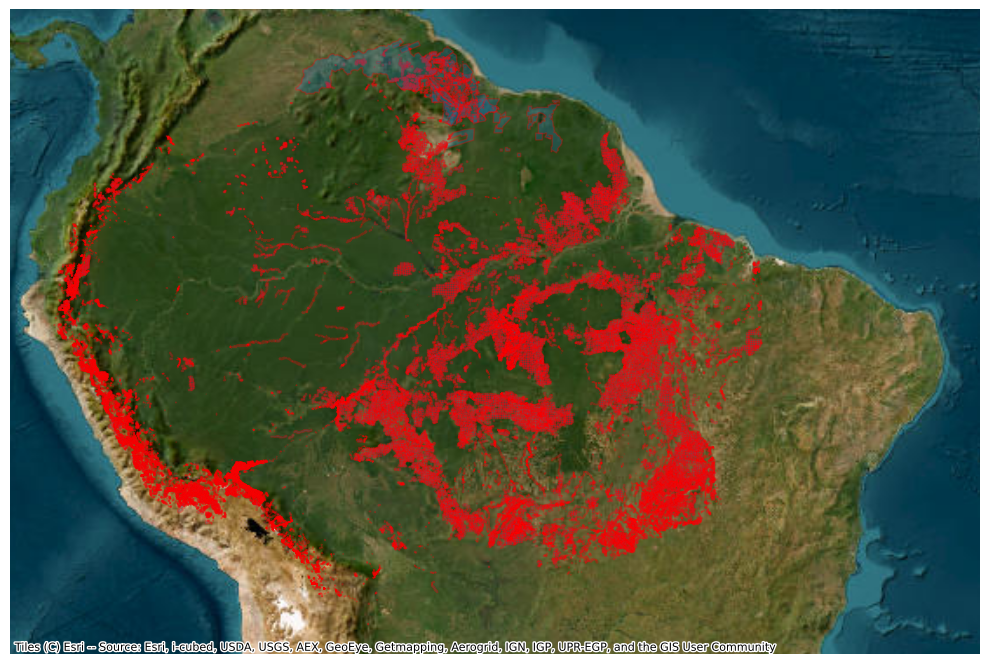

In [ ]:
# Visualizacao do .SHP do RAISG de ZonasMinerais_jun2025 (https://www.raisg.org/pt-br/mapas/)
# !pip install geopandas contextily xyzservices matplotlib
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily  as ctx
import xyzservices.providers as xyz

caminho_shp = '/content/mineria.shp' # ZonasMinerais_jun2025.zip

gdf = gpd.read_file(caminho_shp)
if gdf.crs is None:
  gdf = gdf.set_crs(4326)
gdf_3857 = gdf.to_crs(3857)
ax = gdf_3857.plot(
  figsize=(10, 10),
  alpha=0.3,
  edgecolor="red",
  linewidth=1
)

ctx.add_basemap(ax, source=xyz.Esri.WorldImagery)
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [ ]:
# Script com qtd de chips com e sem garimpo usando .SHP para calculo
# !pip install geopandas shapely pyproj rtree
import math
import geopandas as gpd
from shapely.geometry import box
from pyproj import CRS

# 2 pontos do retangulo (lon, lat)
P1 = (-58.338611, -8.546111)
P2 = (-54.683611, -4.495833)

GARIMPO_SHP = "/content/mineria.shp" # .shp de garimpo
PIX_SIZE_M = 10 # Sentinel-2 a 10 m
CHIP_PX = 128
CHIP_M = PIX_SIZE_M * CHIP_PX # 1280 m

# utils
def utm_epsg(lon, lat):
    zone = int(math.floor((lon + 180) / 6) + 1)
    return 32600 + zone if lat >= 0 else 32700 + zone # norte/sul

# AOI em UTM (m)
xmin = min(P1[0], P2[0]); ymin = min(P1[1], P2[1])
xmax = max(P1[0], P2[0]); ymax = max(P1[1], P2[1])

aoi_ll = gpd.GeoDataFrame(geometry=[box(xmin, ymin, xmax, ymax)], crs="EPSG:4326")
cent = aoi_ll.geometry.iloc[0].centroid
epsg = utm_epsg(cent.x, cent.y)
aoi = aoi_ll.to_crs(epsg)

xmin_m, ymin_m, xmax_m, ymax_m = aoi.total_bounds
width_m  = xmax_m - xmin_m
height_m = ymax_m - ymin_m

# Total de Chips
cols = math.ceil(width_m  / CHIP_M)
rows = math.ceil(height_m / CHIP_M)
total_chips = rows * cols

print(f"CRS UTM: EPSG:{epsg}")
print(f"Dimensão AOI (m): {width_m:.1f} × {height_m:.1f}")
print(f"Tamanho do chip: {CHIP_M} m")
print(f"Grid: {cols} colunas × {rows} linhas  => TOTAL = {total_chips} chips")

# Cruza regiao com o SHP com contagem simples de intersecao
garimpo = gpd.read_file(GARIMPO_SHP)
if garimpo.crs is None:
    raise ValueError("O .shp nao tem CRS")
garimpo = garimpo.to_crs(epsg)

# recorta o garimpo ao AOI para acelerar
garimpo = gpd.overlay(garimpo, aoi, how="intersection")
if garimpo.empty:
    print("Nenhum poligono de garimpo dentro do AOI.")
    print("Chips com garimpo: 0 (0.00%)")
else:
    # indice espacial (rtree)
    sindex = garimpo.sindex
    chips_garimpo = 0
    # percorre celulas
    for c in range(cols):
        for r in range(rows):
            x0 = xmin_m + c * CHIP_M
            y0 = ymin_m + r * CHIP_M
            cell = box(x0, y0, x0 + CHIP_M, y0 + CHIP_M)
            # descarta se a celula nao intersecta o AOI (bordas)
            if not cell.intersects(aoi.geometry.iloc[0]):
                continue
            # candidatos por bounding box
            cand_idx = list(sindex.intersection(cell.bounds))
            if cand_idx and garimpo.iloc[cand_idx].intersects(cell).any():
                chips_garimpo += 1

    pct = chips_garimpo / total_chips * 100 if total_chips else 0.0
    print(f"Chips com garimpo: {chips_garimpo} ({pct:.2f}%)")


CRS UTM: EPSG:32721
Dimensão AOI (m): 405550.0 × 448367.5
Tamanho do chip: 1280 m
Grid: 317 colunas × 351 linhas  => TOTAL = 111267 chips
Chips com garimpo: 55652 (50.02%)


In [ ]:
# !pip -q install geopandas shapely pyproj rtree rasterio numpy pillow tqdm pandas

# Google Drive Mount
from google.colab import drive
drive.mount('/content/drive')

# Libs
import os, glob, math
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image

import geopandas as gpd
from shapely.geometry import box
from shapely.validation import make_valid # shapely > 2.0
from shapely.errors import GEOSException

import rasterio
from rasterio.windows import Window
from rasterio.windows import bounds as window_bounds
from rasterio.warp import transform as coord_transform

# Parametros
BASE_DIR = "/content/drive/MyDrive/DataSetV3" # pasta base
GARIMPO_DIR = os.path.join(BASE_DIR, "garimpo") # .shp
OUT_POS = os.path.join(BASE_DIR, "com_garimpo")
OUT_NEG = os.path.join(BASE_DIR, "sem_garimpo")
CSV_PATH = os.path.join(BASE_DIR, "manifesto_chips.csv")

os.makedirs(OUT_POS, exist_ok=True)
os.makedirs(OUT_NEG, exist_ok=True)

# chips 128x128 px no grid nativo do raster
TILE_SIZE = 128

# rotulagem por sobreposicao minima (5% da celula)
OVERLAP_THRESHOLD = 0.05

# normalizacao pra PNG (median definida no GEE)
RGB_MIN = 0.02
RGB_MAX = 0.30

# processar 100% dos tiles de cada TIF 
SAMPLE_FRACTION = 1.00

# filtrar apenas Sentinel-2
ONLY_S2 = True

# Utils
def utm_epsg(lon, lat):
    # Escolhe EPSG UTM adequado para lon/lat
    zone = int(math.floor((lon + 180) / 6) + 1)
    return 32600 + zone if lat >= 0 else 32700 + zone

def pick_rgb_bands(src):
    # Retorna indices 0-based das 3 bandas RGB dos exports do GEE (B2,B3,B4) => 4-3-2 => [2,1,0]
    names = src.descriptions
    if names:
        name_to_idx = {n:i for i,n in enumerate(names) if n}
        for triplet in [('B4','B3','B2'), ('SR_B4','SR_B3','SR_B2')]:
            if all(n in name_to_idx for n in triplet):
                return [name_to_idx[triplet[0]], name_to_idx[triplet[1]], name_to_idx[triplet[2]]]
        if src.count >= 3:
            return [2,1,0]
        raise ValueError("Raster tem menos de 3 bandas.")
    else:
        if src.count >= 3:
            return [2,1,0]
        raise ValueError("Raster tem menos de 3 bandas.")

def norm_to_png(arr, vmin=RGB_MIN, vmax=RGB_MAX):
    # Normaliza de [vmin,vmax] para [0,255] uint8 com clip
    arr = np.clip((arr - vmin) / max(vmax - vmin, 1e-6), 0, 1)
    return (arr * 255).astype(np.uint8)

def geom_to_wgs84_bounds_centroid(poly, src_crs):
    # Retorna bounds e centro do poligono em WGS84: (minlon,minlat,maxlon,maxlat, clon, clat)
    minx, miny, maxx, maxy = poly.bounds
    xs = [minx, maxx, (minx+maxx)/2]
    ys = [miny, maxy, (miny+maxy)/2]
    lon, lat = coord_transform(src_crs, "EPSG:4326", xs, ys)
    return lon[0], lat[0], lon[1], lat[1], lon[2], lat[2]

def clean_geometries(gdf):
    # Conserta geometrias invalidas: make_valid e buffer(0)
    try:
        geoms = gdf.geometry.apply(make_valid)
    except Exception:
        geoms = gdf.geometry
    geoms = geoms.buffer(0)
    gdf2 = gdf.copy()
    gdf2["geometry"] = geoms
    # remove vazias/nulas
    gdf2 = gdf2[~gdf2.geometry.is_empty & gdf2.geometry.notnull()]
    return gdf2

# Carrega Shapefile
shp_candidates = sorted(glob.glob(os.path.join(GARIMPO_DIR, "*.shp")))
if not shp_candidates:
    raise FileNotFoundError(f"Nenhum .shp encontrado em {GARIMPO_DIR}")
SHP_PATH = shp_candidates[0]
print("Usando shapefile:", os.path.basename(SHP_PATH))

gdf_raw = gpd.read_file(SHP_PATH)
if gdf_raw.empty:
    raise ValueError("Shapefile carregado, mas vazio.")
gdf_raw = clean_geometries(gdf_raw)

# Lista TIFs (filtrando S2)
tif_list = sorted(glob.glob(os.path.join(BASE_DIR, "*.tif")))
if ONLY_S2:
    tif_list = [p for p in tif_list if "s2" in os.path.basename(p).lower()]
if not tif_list:
    raise FileNotFoundError("Nenhum .tif filtrado encontrado em " + BASE_DIR)

# Loop
rows = []
for tif_path in tqdm(tif_list, desc="Processando TIFs"):
    with rasterio.open(tif_path) as src:
        # shapefile no CRS do raster
        shp_in_raster = gdf_raw.to_crs(src.crs)
        # EPSG UTM para medir area corretamente (centro do raster)
        (minx, miny, maxx, maxy) = src.bounds
        cx = (minx + maxx) / 2
        cy = (miny + maxy) / 2
        lon_c, lat_c = coord_transform(src.crs, "EPSG:4326", [cx], [cy])
        epsg_utm = utm_epsg(lon_c[0], lat_c[0])
        # shapefile em UTM
        shp_in_utm = clean_geometries(shp_in_raster.to_crs(epsg=epsg_utm))
        if shp_in_utm.empty:
            sindex = None
        else:
            sindex = shp_in_utm.sindex
        rgb_idx = pick_rgb_bands(src)  # indices 0-based
        width, height = src.width, src.height
        # numero de janelas completas
        n_cols = width  // TILE_SIZE
        n_rows = height // TILE_SIZE
        total_tiles = n_cols * n_rows
        # quantidade alvo (100%)
        sample_count = max(1, int(total_tiles * SAMPLE_FRACTION))
        processed = 0
        for r in range(n_rows):
            if processed >= sample_count:
                break
            for c in range(n_cols):
                if processed >= sample_count:
                    break
                win = Window(c*TILE_SIZE, r*TILE_SIZE, TILE_SIZE, TILE_SIZE)
                # evita chips totalmente NODATA
                sample = src.read(1, window=win)
                if src.nodata is not None and np.all(sample == src.nodata):
                    continue
                # poligono do chip no CRS do raster
                b = window_bounds(win, transform=src.transform)
                chip_poly_raster = box(*b)
                # reprojeta poligono do chip para UTM para medir area
                chip_poly_utm = gpd.GeoSeries([chip_poly_raster], crs=src.crs).to_crs(epsg=epsg_utm).iloc[0]
                chip_area = chip_poly_utm.area
                # calcula sobreposicao usando indice espacial
                overlap_area = 0.0
                if sindex is not None and chip_area > 0:
                    # candidatos por bbox
                    idxs = list(sindex.intersection(chip_poly_utm.bounds))
                    if idxs:
                        candidates = shp_in_utm.geometry.iloc[idxs]
                        # soma areas de intersecao (ignorando invalidas)
                        for geom in candidates:
                            try:
                                inter = chip_poly_utm.intersection(geom)
                            except GEOSException:
                                inter = chip_poly_utm.intersection(make_valid(geom))
                            if not inter.is_empty:
                                overlap_area += inter.area
                overlap_ratio = float(overlap_area / chip_area) if chip_area > 0 else 0.0
                label_int = 1 if overlap_ratio >= OVERLAP_THRESHOLD else 0
                label_str = "com_garimpo" if label_int == 1 else "sem_garimpo"
                out_dir   = OUT_POS if label_int == 1 else OUT_NEG
                # le as 3 bandas RGN
                rgb = np.stack([src.read(i+1, window=win) for i in rgb_idx], axis=0).astype('float32')
                # normaliza para PNG
                rgb_png = np.stack([norm_to_png(rgb[0]),
                                    norm_to_png(rgb[1]),
                                    norm_to_png(rgb[2])], axis=0)
                # salva PNG (nome com localizacao do centro)
                minlon, minlat, maxlon, maxlat, clon, clat = geom_to_wgs84_bounds_centroid(chip_poly_raster, src.crs)
                base_name = os.path.splitext(os.path.basename(tif_path))[0]
                png_name  = f"{base_name}_r{r:04d}_c{c:04d}_lat{clat:+.5f}_lon{clon:+.5f}_{label_str}.png"
                png_path  = os.path.join(out_dir, png_name)
                Image.fromarray(np.transpose(rgb_png, (1,2,0))).save(png_path, format="PNG")
                # bounds UTM tambem (para auditoria)
                xmin_m, ymin_m, xmax_m, ymax_m = chip_poly_utm.bounds
                rows.append({
                    # arquivos / rotulos
                    "png_path": os.path.relpath(png_path, BASE_DIR),
                    "tif_source": os.path.basename(tif_path),
                    "label_str": label_str,
                    "label_int": label_int,
                    # tile
                    "tile_row": r,
                    "tile_col": c,
                    "tile_size_px": TILE_SIZE,
                    # metricas de sobreposicao (UTM)
                    "utm_epsg": int(epsg_utm),
                    "overlap_area_m2": float(overlap_area),
                    "overlap_ratio": float(overlap_ratio),
                    "xmin_m": float(xmin_m), "ymin_m": float(ymin_m),
                    "xmax_m": float(xmax_m), "ymax_m": float(ymax_m),
                    # localizacao (WGS84)
                    "xmin": float(minlon), "ymin": float(minlat),
                    "xmax": float(maxlon), "ymax": float(maxlat),
                    "centroid_lon": float(clon), "centroid_lat": float(clat),
                    # metadados do raster
                    "crs_raster": str(src.crs),
                    "transform": tuple(src.transform),
                    "width_px": int(width),
                    "height_px": int(height),
                    "bands_used": [src.descriptions[i] if (src.descriptions and src.descriptions[i]) else f"band_{i+1}" for i in rgb_idx],
                    "dtype_src": str(src.dtypes[0]),
                    "nodata": None if src.nodata is None else float(src.nodata),
                })
                processed += 1 # conta o chip

# salva manifesto em csv
df = pd.DataFrame(rows)
df.to_csv(CSV_PATH, index=False)

print(f"CSV salvo em: {CSV_PATH}")
print(f"Total de chips na amostra: {len(df)}")
print(f"Positivos (com_garimpo): {int((df['label_int']==1).sum())} | Negativos (sem_garimpo): {int((df['label_int']==0).sum())}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.6/507.6 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 87.3 MB/s eta 0:00:00
Mounted at /content/drive
Usando shapefile: mineria.shp


Streaming output truncated to the last 5000 lines.
/tmp/ipython-input-2962434788.py:78: RuntimeWarning: invalid value encountered in cast
  return (arr * 255).astype(np.uint8)
/tmp/ipython-input-2962434788.py:78: RuntimeWarning: invalid value encountered in cast
  return (arr * 255).astype(np.uint8)
/tmp/ipython-input-2962434788.py:78: RuntimeWarning: invalid value encountered in cast
  return (arr * 255).astype(np.uint8)
/tmp/ipython-input-2962434788.py:78: RuntimeWarning: invalid value encountered in cast
  return (arr * 255).astype(np.uint8)
/tmp/ipython-input-2962434788.py:78: RuntimeWarning: invalid value encountered in cast
  return (arr * 255).astype(np.uint8)
/tmp/ipython-input-2962434788.py:78: RuntimeWarning: invalid value encountered in cast
  return (arr * 255).astype(np.uint8)
/tmp/ipython-input-2962434788.py:78: RuntimeWarning: invalid value encountered in cast
  return (arr * 255).astype(np.uint8)
/tmp/ipython-input-2962434788.py:78: RuntimeWarning: invalid value encount

CSV salvo em: /content/drive/MyDrive/DataSetV3/manifesto_chips.csv
Total de chips na amostra: 111584
Positivos (com_garimpo): 55541 | Negativos (sem_garimpo): 56043
